<h1><span style="font-size:34px">Credit Card Revenue Leakage & Cross-Sell Opportunity Analysis</span></h1>


***
## Business Context:
## Banks often lose revenue due to inactive cards or low spenders. Your job is to analyze usage patterns and identify revenue leakage and cross-sell segments.
***

In [2]:
# Import all essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

# Display settings for large outputs
pd.set_option('display.max_columns', None)

In [6]:
# Load dataset
df = pd.read_csv("credit_card_revenue_leakage.csv")

# Preview top 10 rows
df.head(10)

,customer_id,card_type,monthly_spend,payment_behavior,fees_charged,late_fees_collected,income_bracket,customer_lifetime_months,occupation,is_active,credit_limit,transactions_last_month
0,CUST149899,Titanium,1828.26,Minimum Due,461.85,82.12,High,60,Self-Employed,1,64000,25
1,CUST124585,Platinum,11301.76,Late,478.72,66.95,Medium,22,Self-Employed,1,110000,23
2,CUST105721,Gold,20808.79,Full Payment,473.63,48.34,Low,101,Retired,1,169000,28
3,CUST152960,Gold,2411.97,On-Time,555.68,123.99,Medium,91,Retired,0,88000,5
4,CUST134069,Platinum,6888.45,On-Time,420.43,118.15,Low,11,Retired,1,112000,17
5,CUST114225,Gold,4453.88,Full Payment,335.30,23.40,High,103,Salaried,1,161000,31
6,CUST110385,Silver,296.33,Late,428.56,47.85,High,103,Student,1,136000,30
7,CUST122986,Silver,2955.51,On-Time,509.21,40.27,Very High,113,Salaried,1,214000,6
8,CUST139069,Silver,19882.33,Late,490.73,NaN,High,99,Salaried,1,114000,30
9,CUST142230,Silver,NaN,Late,647.32,NaN,High,61,Retired,1,229000,13


### Basic Data Checks
### Check shape, null values, datatypes, and duplicates.

In [8]:
# Shape and datatypes
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)

Shape: (68000, 12)

Data Types:
 customer_id                  object
card_type                    object
monthly_spend               float64
payment_behavior             object
fees_charged                float64
late_fees_collected         float64
income_bracket               object
customer_lifetime_months      int64
occupation                   object
is_active                     int64
credit_limit                  int64
transactions_last_month       int64
dtype: object


In [10]:
# Null value summary
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 customer_id                    0
card_type                      0
monthly_spend               3400
payment_behavior               0
fees_charged                3400
late_fees_collected         3400
income_bracket                 0
customer_lifetime_months       0
occupation                     0
is_active                      0
credit_limit                   0
transactions_last_month        0
dtype: int64


In [ ]:
#Missing values found in: monthly_spend, fees_charged, late_fees_collected (3,400 each)

In [14]:
# Check for duplicates
df.duplicated().sum()

0

In [33]:
#Clean Missing Values
df['monthly_spend'].fillna(0, inplace=True)
df['fees_charged'].fillna(0, inplace=True)
df['late_fees_collected'].fillna(0, inplace=True)



In [35]:
# Confirm
df.isnull().sum()

customer_id                 0
card_type                   0
monthly_spend               0
payment_behavior            0
fees_charged                0
late_fees_collected         0
income_bracket              0
customer_lifetime_months    0
occupation                  0
is_active                   0
credit_limit                0
transactions_last_month     0
spend_segment               0
dtype: int64

## EDA (Exploratory Data Analysis)

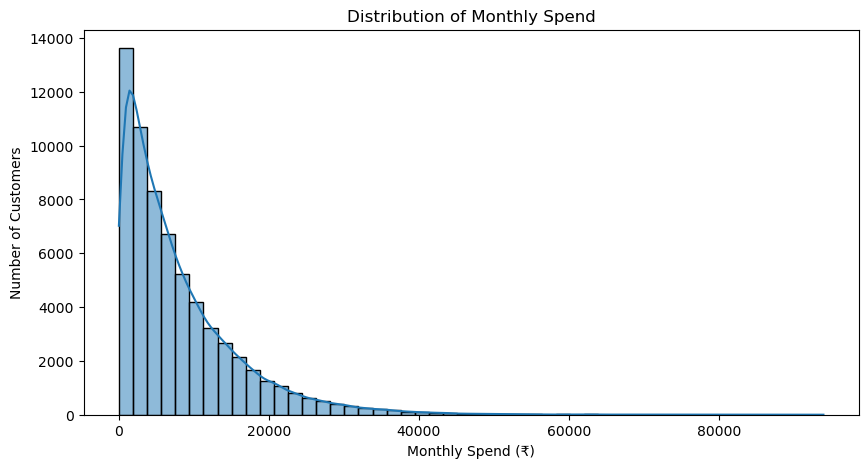

In [19]:
#Distribution of Monthly Spend
plt.figure(figsize=(10, 5))
sns.histplot(df['monthly_spend'], bins=50, kde=True)
plt.title('Distribution of Monthly Spend')
plt.xlabel('Monthly Spend (₹)')
plt.ylabel('Number of Customers')
plt.show()

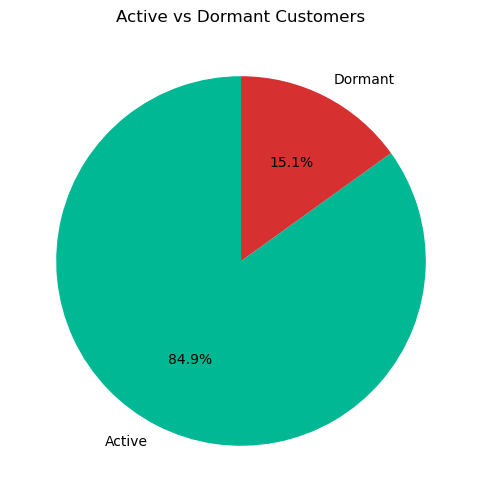

In [23]:
#Active vs Dormant Customers
activity_counts = df['is_active'].value_counts()
labels = ['Active', 'Dormant']

plt.figure(figsize=(6, 6))
plt.pie(activity_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#00b894', '#d63031'])
plt.title('Active vs Dormant Customers')
plt.show()


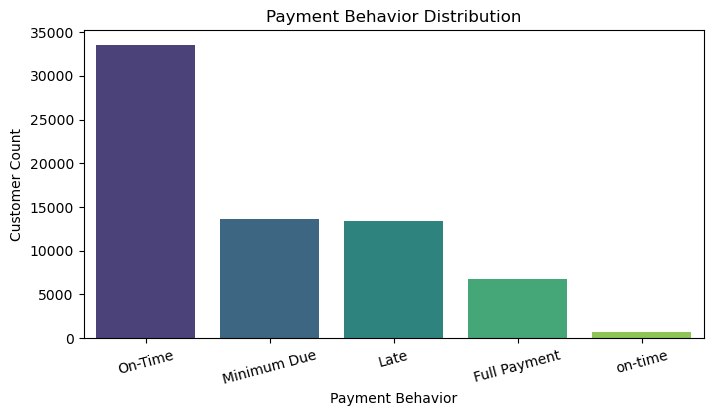

In [29]:
# Payment Behavior Breakdown
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='payment_behavior', order=df['payment_behavior'].value_counts().index, palette='viridis')
plt.title('Payment Behavior Distribution')
plt.ylabel('Customer Count')
plt.xlabel('Payment Behavior')
plt.xticks(rotation=15)
plt.show()


In [39]:
#There is data Quality Issue we can see in oabove chart as  payment_behavior has inconsistent capitalization: "On-Time" vs "on-time".
#Lets  Fix Inconsistent Payment Behavior Values

# Standardize text values to title case (e.g., 'on-time' -> 'On-Time')
df['payment_behavior'] = df['payment_behavior'].str.title()

In [41]:
# Check the fixed unique values
df['payment_behavior'].value_counts()

payment_behavior
On-Time         34215
Minimum Due     13608
Late            13397
Full Payment     6780
Name: count, dtype: int64

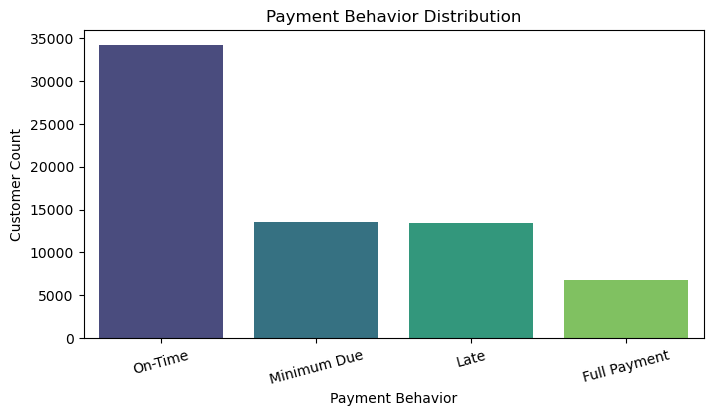

In [45]:
# Lets Try Now Payment Behavior Breakdown If issue is fixed or not 
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='payment_behavior', order=df['payment_behavior'].value_counts().index, palette='viridis')
plt.title('Payment Behavior Distribution')
plt.ylabel('Customer Count')
plt.xlabel('Payment Behavior')
plt.xticks(rotation=15)
plt.show()


#### We'll segment customers into:
#### High Spender: monthly_spend > ₹10,000
#### Low Spender: monthly_spend between ₹1 and ₹10,000
#### Dormant: monthly_spend is NaN or 0 

In [31]:
def categorize_customer(spend):
    if pd.isna(spend) or spend == 0:
        return 'Dormant'
    elif spend > 10000:
        return 'High Spender'
    else:
        return 'Low Spender'

df['spend_segment'] = df['monthly_spend'].apply(categorize_customer)
df['spend_segment'].value_counts()


spend_segment
Low Spender     46062
High Spender    18538
Dormant          3400
Name: count, dtype: int64

# Revenue Leakage Analysis

In [48]:
#Total Revenue collected so far 
total_revenue = df['fees_charged'].sum() + df['late_fees_collected'].sum()
print(f"✅ Total Revenue Collected: ₹{total_revenue:,.0f}")


✅ Total Revenue Collected: ₹38,751,919


In [50]:
#Leakage from Dormant Customers
dormant_df = df[df['spend_segment'] == 'Dormant']

leakage_dormant = dormant_df[['fees_charged', 'late_fees_collected']].sum().sum()
print(f"⚠️ Revenue Leakage from Dormant Customers: ₹{leakage_dormant:,.0f}")

⚠️ Revenue Leakage from Dormant Customers: ₹1,923,077


In [54]:
#lets Summarize 
summary = df.groupby('spend_segment')[['fees_charged', 'late_fees_collected']].sum()
summary['total_revenue'] = summary['fees_charged'] + summary['late_fees_collected']
summary

,fees_charged,late_fees_collected,total_revenue
spend_segment,,,
Dormant,1601976.54,321100.17,1923076.71
High Spender,8783468.51,1760569.87,10544038.38
Low Spender,21906310.71,4378492.75,26284803.46


# Cross-Sell Opportunity Analysis

## Logic to Identify Cross-Sell Candidates:
We'll use 3 smart rules:
High Spenders → Ideal for premium cards or travel cards
Low Spenders with high income → EMI cards or personal loans
Good Payment Behavior → Low-risk customers for credit upgrades

In [57]:
premium_candidates = df[
    (df['spend_segment'] == 'High Spender') &
    (df['payment_behavior'] == 'On-Time')
]

print("💳 Premium Card Cross-Sell Candidates:", premium_candidates.shape[0])

💳 Premium Card Cross-Sell Candidates: 9291


In [91]:
#Low Spenders with High Income → EMI Card Cross-Sell
#Let’s assume “High Income” is in the top 2 brackets: "1L+" and "50K-1L"
emi_candidates = df[
    (df['spend_segment'] == 'Low Spender') &
    (df['income_bracket'].isin(['50K-1L', '1L+'])) &
    (df['payment_behavior'] == 'On-Time')
]

print("📦 EMI/Loan Cross-Sell Candidates:", emi_candidates.shape[0])


📦 EMI/Loan Cross-Sell Candidates: 0


In [95]:
# Export to CSV for Power BI Dashboard Creation
df.to_csv('cleaned_credit_card_data.csv', index=False)